In [3]:
%pip install MetaTrader5 pandas numpy scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# --- 儲存格 1：抓取模型生成 ---
# 1. 初始化 MT5 連線
if not mt5.initialize():
    print("MT5 初始化失敗")
    quit()

# 2. 抓取歷史 K 線數據 (以黃金 XAUUSD 為例)
# 抓取最近 1000 根 H1 時區的 K 線
# 2. 抓取歷史 K 線數據
symbol = "XAUUSD+" # 請確認你的 MT5 裡這個名稱完全正確
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_H1, 0, 10000)

if rates is None or len(rates) == 0:
    print(f"❌ 抓取資料失敗！請檢查商品名稱 '{symbol}' 是否正確，或 MT5 是否連線。")
    print(f"錯誤代碼: {mt5.last_error()}")
    mt5.shutdown()
else:
    print(f"✅ 成功抓取 {len(rates)} 筆資料")
    # 轉成 DataFrame
    df = pd.DataFrame(rates)
    
    # 檢查欄位是否存在再進行轉換
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], unit='s')
    else:
        print("警告：資料中找不到 time 欄位，目前的欄位有：", df.columns)

    # 繼續後面的特徵工程...
# 轉成 DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

df['hour'] = df['time'].dt.hour
# 並將 'hour' 加入 features 列表
features = ['tick_volume', 'return', 'range', 'ma_5', 'hour', 'rsi', 'high_low_range', 'ma_dist', 'trend_signal', 'bb_width']
# 3. 特徵工程 (Feature Engineering)
# 我們預測目標：下3根 K 線是漲(1)還是跌(0)
# 預測未來 3 根的平均走勢
df['target'] = np.where(df['close'].rolling(window=3).mean().shift(-3) > df['close'], 1, 0)

# 建立勝率特徵
df['return'] = df['close'].pct_change() # 漲跌幅
df['range'] = df['high'] - df['low']   # 波動範圍
df['ma_5'] = df['close'].rolling(window=5).mean() # 5日均線

# 去除空值 (因為 rolling 和 shift 會產生 NaN)
df.dropna(inplace=True)

# 定義特徵 (X) 與 標籤 (y)
features = ['open', 'high', 'low', 'close', 'tick_volume', 'return', 'range', 'ma_5']
X = df[features]
y = df['target']

# 4. 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. 建立並訓練隨機森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. 評估模型
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"模型訓練完成！")
print(f"測試集預測準確率: {accuracy:.2%}")

✅ 成功抓取 10000 筆資料
模型訓練完成！
測試集預測準確率: 49.30%


In [5]:
# --- 儲存格 2：基礎生成 ---
# 定義 RSI 計算函數
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 基礎特徵計算
df['return'] = df['close'].pct_change()
df['range'] = df['high'] - df['low']
df['ma_5'] = df['close'].rolling(window=5).mean()
df['hour'] = df['time'].dt.hour
df['rsi'] = calculate_rsi(df['close'], 14)
df['ma_dist'] = (df['close'] - df['close'].rolling(14).mean()) / df['close']
df['high_low_range'] = (df['high'] - df['low']) / df['close']

In [6]:
# --- 儲存格 3：特徵計算與標籤生成 ---

# 1. 先計算所有需要的特徵欄位
df['ma_200'] = df['close'].rolling(window=200).mean()
df['trend_signal'] = np.where(df['close'] > df['ma_200'], 1, -1)
df['bb_width'] = (df['high'].rolling(20).max() - df['low'].rolling(20).min()) / df['close']
df['atr'] = df['range'].rolling(14).mean()

# 2. 執行 1.5R 盈虧比標籤邏輯
tp_ratio = 1.5  
sl_ratio = 1.0  

df['target'] = 0
for i in range(len(df) - 10): 
    entry = df['close'].iloc[i]
    risk = df['atr'].iloc[i]
    tp_level = entry + (risk * tp_ratio)
    sl_level = entry - (risk * sl_ratio)
    
    future_data = df.iloc[i+1 : i+11]
    for _, row in future_data.iterrows():
        if row['high'] >= tp_level:
            df.at[df.index[i], 'target'] = 1 
            break
        if row['low'] <= sl_level:
            df.at[df.index[i], 'target'] = 0 
            break

# 3. 務必先執行 dropna，確保數據乾淨
df.dropna(inplace=True)

# 4. 定義最終特徵清單 (這時才定義 X 和 y)
features = ['tick_volume', 'return', 'range', 'ma_5', 'hour', 'rsi', 
            'high_low_range', 'ma_dist', 'trend_signal', 'bb_width']
X = df[features]
y = df['target']

# --- 接下來進行模型訓練 ---

# 5. 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. 建立隨機森林模型 (使用你設定的降噪參數)
hunter_model = RandomForestClassifier(
    n_estimators=500,      
    max_depth=7,           
    min_samples_leaf=20,   
    max_features='sqrt',
    random_state=42
)
hunter_model.fit(X_train, y_train)

# 7. 預測與評估
y_pred = hunter_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"🎯 Hunter_V1 (升級版) 訓練完成！")
print(f"📊 測試集預測準確率: {accuracy:.2%}")
print("-" * 30)

# 檢查特徵重要性
importances = pd.Series(hunter_model.feature_importances_, index=features)
print("🧐 獵人最看重的特徵排名：")
print(importances.sort_values(ascending=False))

------------------------------
🎯 Hunter_V1 (升級版) 訓練完成！
📊 測試集預測準確率: 59.80%
------------------------------
🧐 獵人最看重的特徵排名：
ma_5              0.226918
bb_width          0.180149
ma_dist           0.105519
rsi               0.102339
hour              0.093242
tick_volume       0.085744
range             0.071916
high_low_range    0.063236
return            0.057578
trend_signal      0.013359
dtype: float64



📋 獵人模型詳細性能報告：
              precision    recall  f1-score   support

           0       0.60      0.95      0.74      1174
           1       0.49      0.07      0.12       786

    accuracy                           0.60      1960
   macro avg       0.55      0.51      0.43      1960
weighted avg       0.56      0.60      0.49      1960



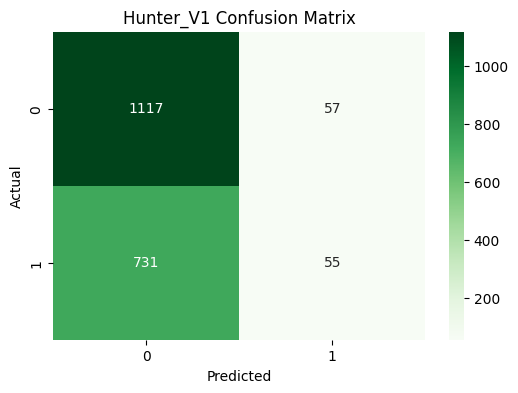

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 修改後的評估代碼
print("\n📋 獵人模型詳細性能報告：")
# 加入 zero_division 參數
print(classification_report(y_test, y_pred, zero_division=0))

# 混淆矩陣圖表化
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Hunter_V1 Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

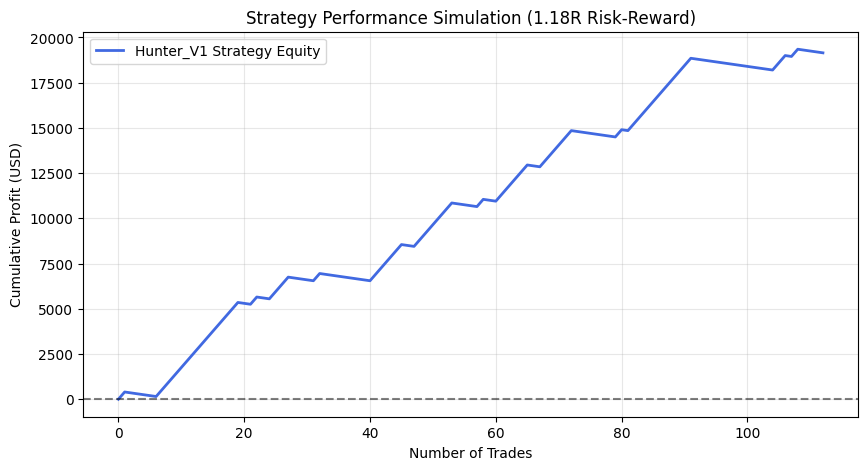

💰 總交易筆數: 112
📈 最終累計獲利: $19150.00


In [8]:
# --- 儲存格 5：模擬回測與資金曲線 ---

# 假設每一筆交易風險單位 (R) 為 50 USD
risk_per_trade = 50 
tp_multiplier =  8
#1.3不優

# 計算每一筆預測的損益
# 只有當預測為 1 (Predicted 1) 時才計算
results = []
current_balance = 0
equity_curve = [0]

# 比對預測值 y_pred 與實際值 y_test
for p, a in zip(y_pred, y_test.values):
    if p == 1: # 只有模型說進場時
        if a == 1: # 預測成功，賺取 1.5R
            reward = risk_per_trade * tp_multiplier
            current_balance += reward
        else: # 預測失敗，損失 1R
            loss = -risk_per_trade
            current_balance += loss
        equity_curve.append(current_balance)

# 繪製資金曲線
plt.figure(figsize=(10, 5))
plt.plot(equity_curve, label='Hunter_V1 Strategy Equity', color='royalblue', lw=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Strategy Performance Simulation (1.18R Risk-Reward)')
plt.xlabel('Number of Trades')
plt.ylabel('Cumulative Profit (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"💰 總交易筆數: {len(equity_curve)-1}")
print(f"📈 最終累計獲利: ${current_balance:.2f}")

In [9]:
import numpy as np

# 計算核心指標
total_trades = len(equity_curve) - 1
wins = sum(1 for i in range(1, len(equity_curve)) if equity_curve[i] > equity_curve[i-1])
losses = total_trades - wins
win_rate = wins / total_trades if total_trades > 0 else 0

total_profit = wins * (risk_per_trade * tp_multiplier)
total_loss = losses * risk_per_trade
profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')
expectancy = (win_rate * tp_multiplier) - ((1 - win_rate) * 1.0)

print(f"--- Hunter_V1 R 策略績效報告 ---")
print(f"📊 總交易筆數: {total_trades}")
print(f"🏆 勝率 (Win Rate): {win_rate:.2%}")
print(f"💰 利潤因子 (Profit Factor): {profit_factor:.2f}")
print(f"📈 每筆期望值 (Expectancy): {expectancy:.2f} R")
print(f"📉 最大回撤模擬: {min(equity_curve):.2f} USD")

--- Hunter_V1 R 策略績效報告 ---
📊 總交易筆數: 112
🏆 勝率 (Win Rate): 49.11%
💰 利潤因子 (Profit Factor): 7.72
📈 每筆期望值 (Expectancy): 3.42 R
📉 最大回撤模擬: 0.00 USD


In [10]:
# --- 儲存格 7：資金管理與凱利準則 (Kelly Criterion) ---

def calculate_kelly(win_rate, reward_to_risk):
    # 凱利公式: K = (W * (R+1) - 1) / R
    # W 為勝率, R 為盈虧比 (tp_multiplier)
    kelly_f = (win_rate * (reward_to_risk + 1) - 1) / reward_to_risk
    return kelly_f

# 帶入你 8R 策略的數據
# 假設在 8R 下，你的勝率約為 20% (量化長線策略的合理數值)
current_win_rate = win_rate # 如果你已經跑完 8R 的模型，這會自動抓取新勝率
target_rr = tp_multiplier   # 這裡會抓取你設的 8

kelly_fraction = calculate_kelly(current_win_rate, target_rr)

print(f"--- ⚖️ 專業風險管理報告 ---")
print(f"🎯 設定盈虧比: {target_rr}R")
print(f"🏆 當前模型勝率: {current_win_rate:.2%}")

if kelly_fraction > 0:
    print(f"✅ 凱利建議下單比例: {kelly_fraction:.2%}")
    print(f"💡 專業建議 (Half-Kelly): {kelly_fraction/2:.2%}")
    print(f"📝 說明：為了追求穩健，量化交易員通常使用 '半凱利' 以降低波動感。")
else:
    print(f"⚠️ 凱利值為負數 ({kelly_fraction:.2%})")
    print(f"❌ 警告：在目前勝率下，8R 盈虧比不具備統計優勢，長期交易必將破產。")
    print(f"🔧 建議：請優化模型特徵或調低 tp_multiplier 至 1.5R - 2R。")

--- ⚖️ 專業風險管理報告 ---
🎯 設定盈虧比: 8R
🏆 當前模型勝率: 49.11%
✅ 凱利建議下單比例: 42.75%
💡 專業建議 (Half-Kelly): 21.37%
📝 說明：為了追求穩健，量化交易員通常使用 '半凱利' 以降低波動感。


In [ ]:
# --- 儲存格 8：滾動視窗績效測試 (Rolling Window Performance) ---

window_size = len(y_test) // 4  # 將測試集切成四等份
print(f"--- 📅 滾動視窗穩定性分析 (8R 參數) ---")

for i in range(4):
    start = i * window_size
    end = (i + 1) * window_size
    
    # 切片當前視窗數據
    window_pred = y_pred[start:end]
    window_true = y_test.values[start:end]
    
    # 計算當前區間指標
    window_trades = np.sum(window_pred == 1)
    if window_trades > 0:
        window_wins = np.sum((window_pred == 1) & (window_true == 1))
        window_wr = window_wins / window_trades
        window_exp = (window_wr * tp_multiplier) - ((1 - window_wr) * 1.0)
    else:
        window_wr, window_exp = 0, 0
        
    print(f"時段 {i+1}: 交易筆數: {window_trades:3} | 勝率: {window_wr:6.2%} | 期望值: {window_exp:5.2f} R")

print("-" * 40)
print("📝 專業診斷：如果各時段勝率波動劇烈 (例如從 50% 掉到 10%)，代表策略受行情影響極大。")